# PyMC Toy Problem Example

## Bayesian Inference Model

### Overview
이 예제에서는 Bayesian 추론을 사용하여 컴퓨터 시뮬레이션과 실제 관측 데이터를 결합하는 방법을 보여줍니다.

### Data Model
실제 측정된 데이터 $z$는 다음과 같이 모델링됩니다:

$$
z = \eta(x, t) + e
$$

여기서:
- $\eta(x, t)$: 실제 물리 프로세스 또는 컴퓨터 시뮬레이션 함수
  - $x$: 입력 변수 (예: 공간 좌표, 시간 등)
  - $t$: 모델 파라미터
- $e$: 관측 오차 (랜덤 노이즈)

### Key Assumptions

**완벽한 모델 가정**: 이 예제에서는 컴퓨터 모델이 실제 물리 프로세스를 완벽하게 재현한다고 가정합니다.

> **참고**: Bayesian Model Calibration (Kennedy and O'Hagan, 2001)에서는 모델의 불완전성을 고려하여 오차를 두 부분으로 나눕니다:
> - **Model inadequacy (bias)**: 모델 자체의 한계로 인한 체계적 오차
> - **Measurement error**: 관측 과정에서 발생하는 랜덤 오차
> 
> 하지만 이 예제에서는 단순화를 위해 모델을 완벽하다고 가정하며, $e$는 시뮬레이터 오차와 관측 오차를 모두 포함합니다.

### Gaussian Process Modeling
물리 프로세스 함수 $\eta(x, t)$는 제공되는 컴퓨터 모델 데이터 혹은 측정 데이터에 기반해서 Gaussian Process (GP)로 모델링됩니다.

### Data Types

**1. 컴퓨터 시뮬레이션 데이터**
- 형태: $(y_i, x_i, t_i)$
- $y_i$: 시뮬레이션 코드의 출력값
- $x_i$: 입력 변수
- $t_i$: 시뮬레이션에서 사용된 파라미터값

**2. 실제 관측 데이터**
- 형태: $(z_i, x_i, \theta)$
- $z_i$: 실제 측정값
- $x_i$: 입력 변수 (시뮬레이션과 동일한 조건)
- $\theta$: 실제 물리 프로세스의 파라미터값이자 추정해야하는 확률변수  (미지수)

### Statistical Model

두 종류의 데이터에 대해 다음과 같은 확률적 모델을 설정합니다:

**컴퓨터 시뮬레이션 데이터:**
$$
\begin{align}
y_i &\sim \mathcal{N}(f_{c,i}, \sigma_c^2) \\
f_{c,i} &\sim \text{GP}(\eta(x_i, t_i))
\end{align}
$$

**실제 관측 데이터:**
$$
\begin{align}
z_i &\sim \mathcal{N}(f_{p,i}, \sigma^2) \\
f_{p,i} &\sim \text{GP}(\eta(x_i, \theta))
\end{align}
$$

여기서:
- $f_{c,i}$, $f_{p,i}$: GP에서 나온 함수값
- $\sigma_c^2$: 컴퓨터 시뮬레이션 오차의 분산
- $\sigma^2$: 실제 관측 오차의 분산

### Simplification
이 예제에서는 문제를 단순화하기 위해 $\sigma_c = \sigma$로 가정합니다.

### Goal
MCMC 샘플링을 통해 미지의 파라미터 $\theta$를 추정하고 불확실성을 정량화합니다.  

## 1. 라이브러리 임포트

이 예제에서 사용되는 주요 라이브러리들입니다:

핵심 라이브러리
- **`pymc`**: Bayesian 통계 모델링과 MCMC (Markov Chain Monte Carlo) 추론을 위한 메인 라이브러리
  - 확률적 프로그래밍을 통해 복잡한 Bayesian 모델을 쉽게 구축
  - 다양한 MCMC 샘플러 (NUTS, Metropolis-Hastings 등) 제공
  - Gaussian Process 모델링 지원

- **`numpy`**: 수치 연산과 다차원 배열 처리
  - 기본적인 수학 연산 및 선형대수 연산
  - 데이터 생성, 변환, 통계 계산에 사용

데이터 처리 및 분석
- **`arviz`**: Bayesian 분석 결과의 요약 및 시각화
  - MCMC 체인 진단 및 수렴성 검사
  - 사후 분포 시각화 및 요약 통계
  - Trace plot, posterior plot 등 다양한 시각화 도구 제공

- **`pandas`**: 표 형식 데이터의 입출력 및 분석
  - CSV 파일 읽기/쓰기
  - 데이터프레임 조작 및 전처리
  - 구조화된 데이터 관리

시각화
- **`matplotlib.pyplot`**: 2D 데이터 시각화
  - 플롯 생성 및 커스터마이징
  - 결과 시각화 및 분석 도표 작성

저수준 연산 지원
- **`pytensor.tensor`**: 텐서 연산 지원 (PyMC 내부 연산에 사용)
  - PyMC의 백엔드로 사용되는 심볼릭 텐서 라이브러리
  - 그래디언트 계산 및 자동 미분 지원
  - 직접적으로는 거의 사용하지 않지만 PyMC 내부에서 중요한 역할


In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트

In [ ]:
# c stands for computed, f stands for field (observed physical process).
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")
df_f = pd.read_csv("../dataset/datafield_hourly.csv")

In [ ]:
# - yc : 에너지사용량
# - xc1 : 외기온도
# - xc2 : 상대습도
# - tc1 : 추론하고자 하는 파라미터1 (x3, 기기밀도)
# - tc2 : 추론하고자 하는 파라미터2 (x4, 조명밀도)
# - tc3 : 추론하고자 하는 파라미터3 (x5, COP)

df_c

,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [ ]:
# - yf : 에너지사용량
# - xf1 : 외기온도
# - xf2 : 상대습도

df_f

,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 

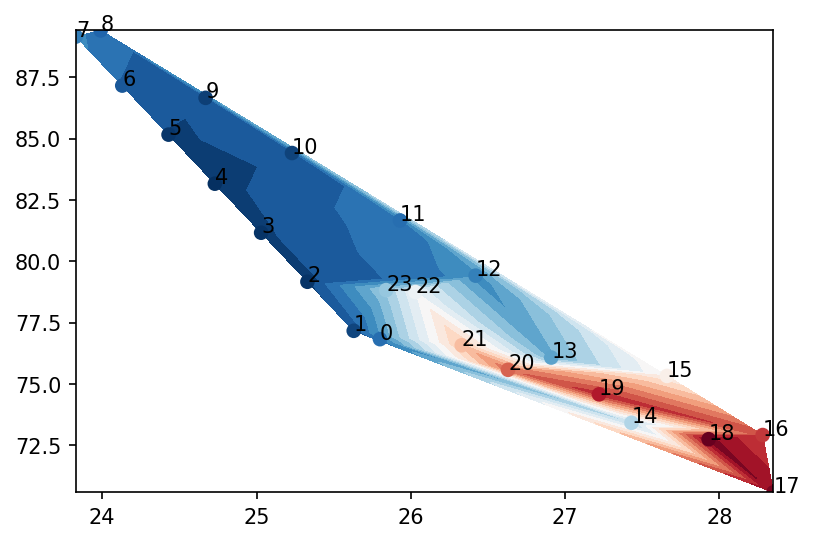

In [ ]:
# 실제 물리 프로세스 데이터(df_f)의 2차원 공간 분포를 시각화
# df_f 구조: [zf, xf1, xf2] - 실제 측정값과 2차원 공간 좌표

# 고해상도 플롯 설정 (6x4 인치, 150 DPI)
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 삼각분할 등고선 플롯 (filled contour)
# df_f.iloc[:, 1]: x1 좌표 (공간의 첫 번째 차원), 건구온도
# df_f.iloc[:, 2]: x2 좌표 (공간의 두 번째 차원), 상대습도도  
# df_f.iloc[:, 0]: zf 값 (실제 측정값, 등고선의 높이로 표현)
# levels=20: 20개의 등고선 레벨로 세밀한 분포 표현
# cmap="RdBu_r": 빨강-파랑 색상 맵 (역순, 높은 값이 파란색)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)

# 실제 데이터 포인트들을 산점도로 표시
# 각 점의 색상은 해당 위치의 측정값(zf)에 따라 결정
ax.scatter(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    c=df_f.iloc[:, 0],
    cmap="RdBu_r"
)

# 각 데이터 포인트에 인덱스 번호를 텍스트로 표시
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],  # x1 좌표
        df_f.iloc[i, 2],  # x2 좌표
        str(i),           # 포인트 인덱스 번호
        color="black"     # 검은색 텍스트
    )

plt.show()

# 4. Bayesian Inference 모델 정의

### 4-1. 모델 정의를 위한 데이터 변수명 설정

In [6]:
df_c.describe()

,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [7]:
df_f.describe()

,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


## 데이터 정규화 (Data Normalization)

### 왜 정규화가 필요한가?

Bayesian 추론과 Gaussian Process 모델링에서 데이터 정규화는 다음과 같은 이유로 필수적입니다:

1. **수치적 안정성**: GP 커널 계산 시 매우 큰 값이나 매우 작은 값으로 인한 수치 오버플로우/언더플로우 방지
2. **MCMC 수렴성**: 정규화된 데이터는 MCMC 샘플러의 수렴 속도를 크게 향상시킵니다
3. **스케일 통일**: 시뮬레이션 데이터와 실제 관측 데이터를 같은 공간에서 비교 가능
4. **하이퍼파라미터 해석**: GP의 length-scale 파라미터 해석이 용이해집니다

### Min-Max 정규화 선택 이유

데이터의 분포 형태를 사전에 알기 어렵기 때문에, 다음과 같은 장점이 있는 **Min-Max 정규화**를 사용합니다:

- **단순성**: 복잡한 분포 가정 없이 직관적인 스케일링
- **유연성**: 모든 분포 형태의 데이터에 적용 가능
- **해석 용이성**: [0, 1] 범위로 모든 변수가 동일한 스케일을 가짐

### 정규화 공식

**Min-Max 정규화**는 다음과 같이 정의됩니다:

$$x_{\text{normalized}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$$

여기서:
- $x_{\min}$: 원본 데이터의 최솟값
- $x_{\max}$: 원본 데이터의 최댓값
- 결과값은 항상 $[0, 1]$ 범위에 위치

### 정규화 전략

**1. 시뮬레이션 데이터 기준 정규화**
- 시뮬레이션 데이터의 통계량을 기준으로 정규화 파라미터 계산
- 정규화 파라미터 저장 (나중에 역변환용)

**2. 실제 데이터에 동일한 파라미터 적용**
- 실제 관측 데이터는 시뮬레이션 데이터의 정규화 파라미터를 그대로 사용
- 두 데이터셋이 같은 스케일 공간에 위치하도록 보장

### 정규화 대상 변수들

1. **출력값**: $y$ (시뮬레이션), $z$ (실제 관측)
2. **공간 좌표**: $x_c$ (시뮬레이션), $x_p$ (실제 관측) 
3. **모델 파라미터**: $t_c$ (시뮬레이션 파라미터)

> **중요**: 특정 파라미터의 경우 음수가 나올 수 없는 물리적 제약으로 인해 하한선이 0으로 고정됩니다. 따라서 $[0, t_{\max}]$ 범위를 $[0, 1]$로 정규화합니다.


In [ ]:
# 데이터 정규화 (Min-Max Scaling)
# 모든 데이터를 [0, 1] 범위로 정규화하여 Gaussian Process 모델링의 수치적 안정성을 확보합니다.

print("=== 컴퓨터 시뮬레이션 데이터 정규화 ===")

# 1. 시뮬레이션 출력값 (y) 정규화
# df_c.iloc[:, 0]: 시뮬레이션 코드의 출력값들
y = df_c.iloc[:, 0].values
y_min = y.min()  # 최솟값 저장 (나중에 역변환용)
y_max = y.max()  # 최댓값 저장 (나중에 역변환용)
y = (y - y_min) / (y_max - y_min)  # Min-Max 정규화: (값 - 최솟값) / (최댓값 - 최솟값)
print(f"y 정규화: 원본 범위 [{y_min:.2f}, {y_max:.2f}] → 정규화 범위 [0, 1]")

# 2. 시뮬레이션 입력 변수 (x_c) 정규화  
# df_c.iloc[:, 1:3]: 공간 좌표 (x1, x2)
x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)  # 각 차원별 최솟값
x_c_max = x_c.max(axis=0)  # 각 차원별 최댓값
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)  # 차원별로 Min-Max 정규화
print(f"x_c 정규화: 각 차원별로 [0, 1] 범위로 변환")

# 3. 시뮬레이션 추가 입력 파라미터, 추정 파라미터터 (t_c) 정규화
# df_c.iloc[:, 3:]: 모델 추추파라미터 (t1, t2, t3)
t_c = df_c.iloc[:, 3:].values
t_c_min = 0  # 하한선을 0으로 고정 (양수 파라미터)
t_c_max = t_c.max(axis=0)  # 각 파라미터별 최댓값
t_c = (t_c - t_c_min) / (t_c_max - t_c_min)  # [0, 최댓값] → [0, 1] 범위로 정규화
print(f"t_c 정규화: [0, {t_c_max}] → [0, 1] 범위로 변환")

print(f"정규화된 데이터 크기: y{y.shape}, x_c{x_c.shape}, t_c{t_c.shape}")

# 4. 실제 관측 데이터 정규화
# 위에서 사용된 정규화 파라미터를 실험 데이터 정규화에도 그대로 적용합니다.
# 이를 통해 관측 데이터와 시뮬레이션 데이터가 같은 스케일에서 비교 가능합니다.
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)  # y의 정규화 파라미터 사용
print(f"z 정규화: y와 동일한 스케일 적용 [{y_min:.2f}, {y_max:.2f}] → [0, 1]")

# 5. 실제 관측 좌표 (x_p) 정규화
# 시뮬레이션 좌표와 같은 스케일을 적용
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)  # x_c의 정규화 파라미터 사용
print(f"x_p 정규화: x_c와 동일한 스케일 적용")

print(f"정규화된 데이터 크기: z{z.shape}, x_p{x_p.shape}")



(240,) (240, 2) (240, 3)
(24,) (24, 2)


### 4-2. PyMC 모델 정의

## PyMC 모델 정의

### 모델 구조 개요

이 섹션에서는 Bayesian 추론을 위한 PyMC 모델을 정의합니다. 모델은 다음과 같은 핵심 구성요소를 포함합니다:

1. **Gaussian Process 커널 정의**
2. **하이퍼파라미터 사전 분포 설정**
3. **데이터 통합 및 관측 모델 구성**
4. **Marginal GP 구현**

### 1. Gaussian Process 하이퍼파라미터

#### Length-Scale 파라미터 (`ls`)
```python
ls = pm.Gamma("ls", alpha=2, beta=0.5, shape=5)
```

- **분포**: Gamma(α=2, β=0.5)
- **차원**: 5차원 (x₁, x₂, t₁, t₂, t₃에 대응)
- **물리적 의미**: 각 입력 차원에서 함수의 변동성 정도
- **제약**: 양수만 가능 (분모에 사용되므로 0이면 안됨)

**수학적 표현**:
$$ls_i \sim \text{Gamma}(2, 0.5), \quad i = 1, 2, 3, 4, 5$$

#### Amplitude 파라미터 (`eta`)
```python
eta = pm.HalfCauchy("eta", beta=1)
```

- **분포**: HalfCauchy(β=1)
- **물리적 의미**: 함수 값의 전체적인 변동 폭
- **제약**: 0 이상 (함수 값의 스케일 결정)

**수학적 표현**:
$$\eta \sim \text{HalfCauchy}(1)$$

### 2. 커널 함수 정의

```python
cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls)
```

**Exponential Quadratic (RBF) 커널**을 사용합니다:

$$k(x_i, x_j) = \eta^2 \exp\left(-\frac{1}{2}\sum_{d=1}^{5}\frac{(x_{i,d} - x_{j,d})^2}{l_d^2}\right)$$

여기서:
- $\eta^2$: 함수 값의 변동 폭
- $l_d$: 각 차원 $d$의 length-scale
- 5차원 입력: $(x_1, x_2, t_1, t_2, t_3)$

### 3. 데이터 통합

#### 입력 데이터 결합
```python
X_c = np.hstack([x_c, t_c])  # 시뮬레이션 데이터
X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)  # 실제 관측 데이터
```

- **시뮬레이션**: $(x_c, t_c)$ → 5차원 입력
- **실제 관측**: $(x_p, \theta)$ → 모든 관측점에서 동일한 $\theta$ 사용

#### 최종 데이터 통합
```python
X = pt.concatenate([X_c, X_p], axis=0)
Y = pt.concatenate([y, z], axis=0)
```

### 4. 모델 파라미터 정의

#### 물리적 파라미터 (`theta`)
```python
theta = pm.Exponential("theta", lam=1, shape=3)
```

- **분포**: Exponential(λ=1)
- **차원**: 3차원 (t₁, t₂, t₃)
- **제약**: 양수만 가능 (물리적 제약)
- **의미**: 실제 물리 프로세스의 미지 파라미터

**수학적 표현**:
$$\theta_i \sim \text{Exponential}(1), \quad i = 1, 2, 3$$

#### 관측 노이즈 (`sigma`)
```python
sigma = pm.HalfNormal("sigma", sigma=0.02)
```

- **분포**: HalfNormal(σ=0.02)
- **의미**: 관측 과정에서 발생하는 랜덤 노이즈
- **제약**: 양수만 가능

**수학적 표현**:
$$\sigma \sim \text{HalfNormal}(0.02)$$

### 5. Marginal Gaussian Process 구현

#### 왜 Marginal GP를 사용하는가?

**Gaussian Noise 가정** 하에서 Marginal GP가 수치적으로 효율적입니다:

**Latent GP 접근법**:
1. $P(\mathbf{f} | X, \eta, l)$에서 $\mathbf{f}$ 샘플링
2. $P(y | \mathbf{f}, \sigma) = \mathcal{N}(\mathbf{f}, \sigma^2)$에서 관측치 예측

**Marginal GP 접근법**:
$$\int P(y | \mathbf{f}, \sigma) P(\mathbf{f} | X, \eta, l) d\mathbf{f}$$

이 적분의 **해석해**가 존재하므로 중간 변수 $\mathbf{f}$ 없이 바로 관측치를 예측할 수 있습니다.

**조건**: $P(y | \mathbf{f}, \sigma)$가 정규분포일 때만 해석해 존재

#### Marginal Likelihood 정의
```python
gp = pm.gp.Marginal(cov_func=cov)
y_z_obs = gp.marginal_likelihood("y_z_obs", X=X, y=Y, sigma=sigma)
```

**수학적 표현**:
$$\log p(Y | X, \theta, \eta, l, \sigma) = -\frac{1}{2}Y^T K^{-1} Y - \frac{1}{2}\log|K| - \frac{n}{2}\log(2\pi)$$

여기서 $K = K_{XX} + \sigma^2 I$ (커널 행렬 + 노이즈 항)

### 6. 모델의 확률적 구조

전체 모델은 다음과 같은 계층적 구조를 가집니다:

$$\begin{align}
\theta &\sim \text{Exponential}(1) \\
ls &\sim \text{Gamma}(2, 0.5) \\
\eta &\sim \text{HalfCauchy}(1) \\
\sigma &\sim \text{HalfNormal}(0.02) \\
Y &\sim \mathcal{N}(0, K_{XX} + \sigma^2 I)
\end{align}$$

여기서 $K_{XX}$는 입력 $X$에 대한 커널 행렬입니다.

### 7. 구현의 장점

1. **수치적 효율성**: Marginal likelihood 사용으로 차원 축소
2. **수렴성**: 적절한 사전 분포로 MCMC 수렴 향상
3. **해석성**: 각 파라미터의 물리적 의미가 명확
4. **확장성**: 다양한 커널과 노이즈 모델로 확장 가능

> **참고**: [PyMC GP Marginal Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Marginal.html)



In [73]:
with pm.Model() as model:
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta).
    # 5차원 인풋 사용 (x1, x2, t1, t2, t3).

    # 0이 아닌 값을 가지는 양수의 분포로 Gamma를 사용합니다 (분모에 들어가기 때문에 0이면 안됨).
    ls = pm.Gamma("ls", alpha=2, beta=0.5, shape=5)

    # 0 혹은 양수 값을 가지는 분포로 HalfCauchy를 사용합니다 (함수 값의 변동 폭에 해당, 0 가능).
    eta = pm.HalfCauchy("eta", beta=1)

    # 가장 기본적인 커널인 Exponential Quadratic을 사용합니다.
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls)

    # 3. 컴퓨터 데이터 정의
    X_c = np.hstack([x_c, t_c])

    # # 컴퓨터 계산 노이즈 정의. 데이터를 정규화 했기 때문에 비교적 작은 값을 사용합니다.
    # sigma_c = pm.HalfNormal("sigma_c", sigma=0.01)
 
    # 4. 물리 모델 가능도 및 관측 정의.

    # theta prior 정의 (양수 값만 가능). t1, t2, t3의 3차원.
    # 파라미터의 하한선은 0으로 가정했기 양수가 나오는 약한 사전 분포를 사용합니다.
    theta = pm.Exponential("theta", lam=1, shape=3)

    # 모든 실험 과정에서 하나의 theta에서 샘플링이 되기 때문에 하나의 파라미터를 모든 관측치에 
    # 복사하여 인풋으로 사용합니다.
    X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)
    
    # 관측 노이즈 정의. 계산보다 에러가 크다고 가정합니다.
    sigma = pm.HalfNormal("sigma", sigma=0.02)

    # 컴퓨터 데이터와 실험 데이터를 하나의 관측치로 정의합니다.
    X = pt.concatenate([X_c, X_p], axis=0)
    Y = pt.concatenate([y, z], axis=0)
    # sigma_all = pt.concatenate([pt.fill(y, sigma_c), pt.fill(z, sigma)], axis=0)

    # 평균값은 0으로 가정합니다 (커널만으로 충분히 함수 형태가 표현되기 때문에 평균값이 0이 됩니다).
    gp = pm.gp.Marginal(cov_func=cov)
    y_z_obs = gp.marginal_likelihood("y_z_obs", X=X, y=Y, sigma=sigma)

    # Prior version... 정리 필요
    # gp = pm.gp.Latent(cov_func=cov)
    # f_c = gp.prior("f_c", X=X_c)
    # y_obs = pm.Normal("y_obs", mu=f_c, sigma=sigma_c, observed=y)

    # 관측 데이터 정의.
    # f_p = gp.prior("f_p", X=X_p)
    # z_obs = pm.Normal("z_obs", mu=f_p, sigma=sigma, observed=z)

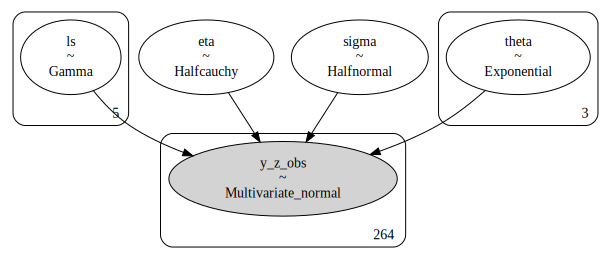

In [53]:
pm.model_to_graphviz(model)

# 5. Sampling 수행

In [43]:
with model:
    trace = pm.sample(
        draws=1000, tune=1000, chains=1, cores=1,
        nuts_sampler="numpyro",
        target_accept=0.95,
        # rogressbar=False,                     # 여기
        # nuts_sampler_kwargs={"progress_bar": False}, 
    )

sample: 100%|██████████| 2000/2000 [02:33<00:00, 13.00it/s, 7 steps of size 1.62e-01. acc. prob=0.94] 
Only one chain was sampled, this makes it impossible to run some convergence checks


$l$, `ls`가 큰 값을 가진다는 것은 해당 차원의 인자 값이 서로 크게 달라도 커널 값의 변화가 작다는 뜻입니다.  
이는 해당 변수가 중요하지 않다는 의미로 해석할 여지가 있습니다. 변수의 스케일에도 영향을 받기 때문에 해석에 주의가 필요합니다.

아래 시각화에서 2, 3, 4 차원, 즉 t1, t2, t3의 중요도는 위치에 비해 낮은 것으로 보입니다. 

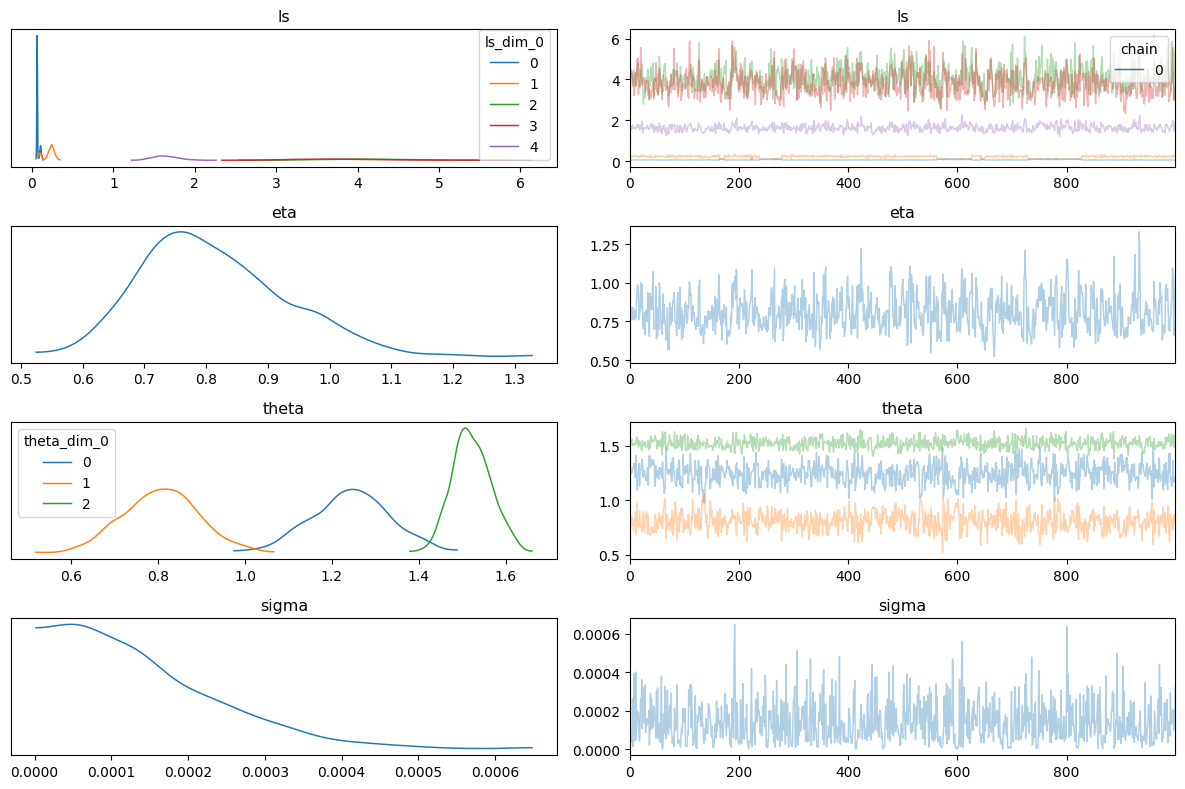

In [44]:
az.plot_trace(trace, legend=True)
plt.tight_layout()
plt.show()

원래 차원으로 복원하여 함수 파라미터 시각화

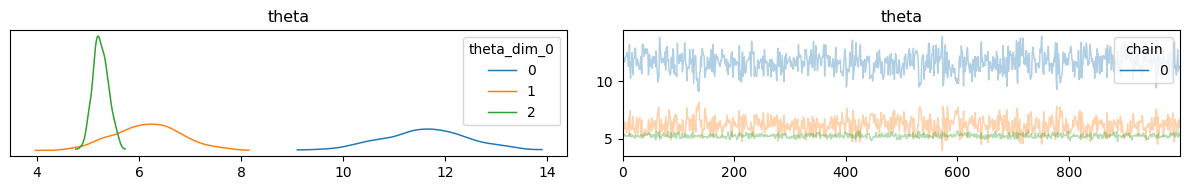

In [92]:
trace_ = trace.copy()
trace_.posterior.theta.values *= t_c_max[None, None, :]

az.plot_trace(trace_, legend=True, var_names=["theta"])
plt.tight_layout()
plt.show()

함수 파라미터 0, 1의 강한 상관관계가 관찰됩니다.

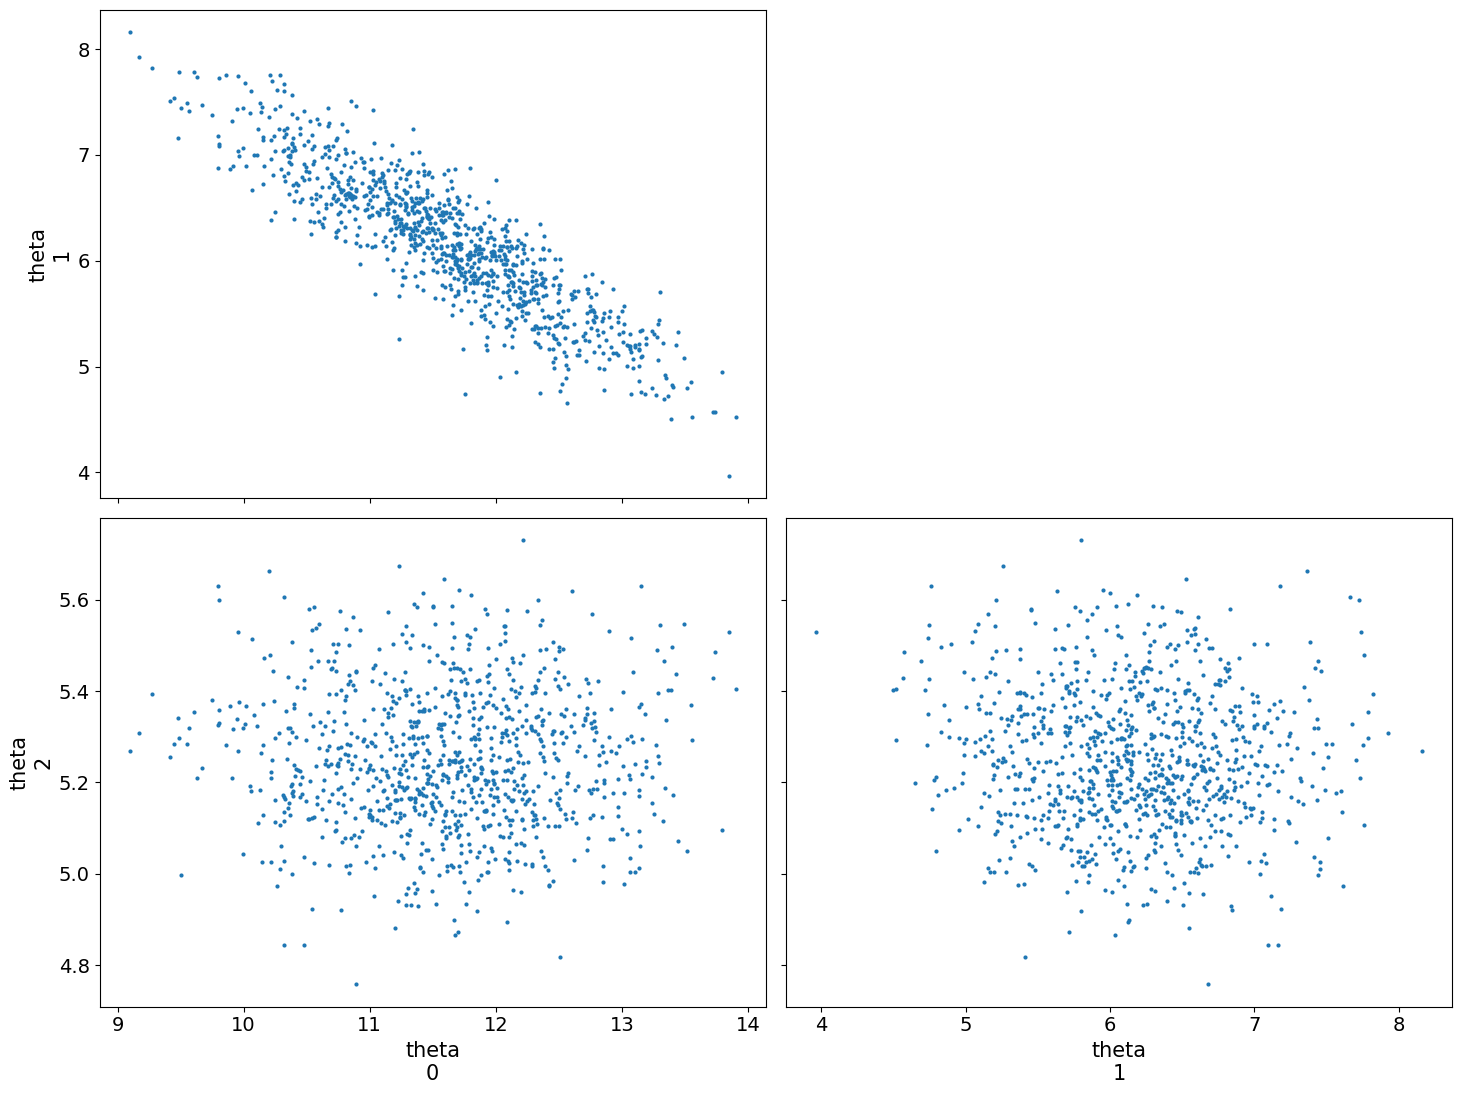

In [93]:
az.plot_pair(trace_, var_names=["theta"])
plt.tight_layout()
plt.show()

In [46]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

1차원 데이터와 유사한 데이터를 생성하기 위하여 1 - 7번 포인트를 연결하는 직선에 대하여 샘플링

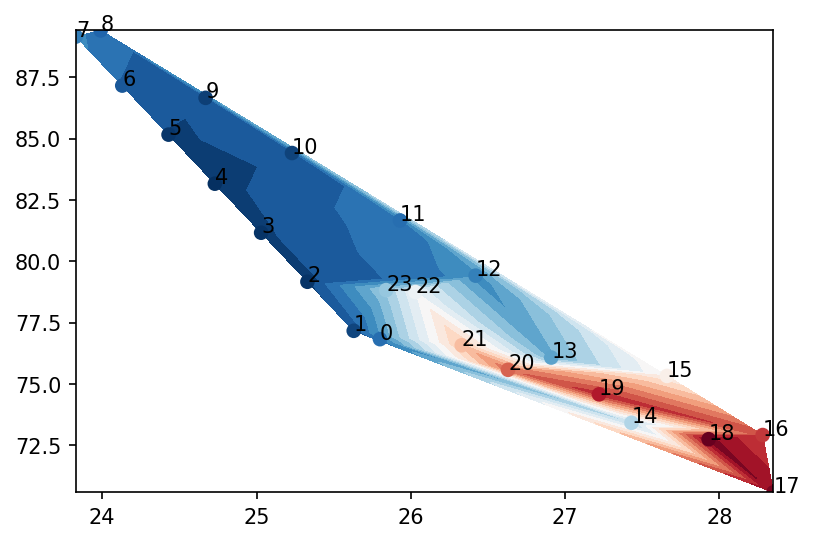

In [61]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)
ax.scatter(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    c=df_f.iloc[:, 0],
    cmap="RdBu_r"
)

# Write data point index.
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],
        df_f.iloc[i, 2],
        str(i),
        color="black"
    )

plt.show()

In [74]:
# 새로운 예측 포지션 정의.
x1 = np.linspace(x_p[1, 0], x_p[7, 0], 100)
x2 = np.linspace(x_p[1, 1], x_p[7, 1], 100)
x_p_new = np.stack([x1, x2], axis=1)
X_p_new = pt.concatenate([x_p_new, pt.tile(theta, (x_p_new.shape[0], 1))], axis=1)

with model:
    # Posterior Predictive Sampling.
    # y_pred = gp.conditional("y_pred", Xnew=X_c, pred_noise=True)
    # z_pred = gp.conditional("z_pred", Xnew=X_p, pred_noise=True)
    z_pred = gp.conditional("z_pred", Xnew=X_p_new, pred_noise=True)

    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["z_pred"],
    )

Sampling: [z_pred]


Output()

In [76]:
# GP 결과를 시각화하는 함수.
from pymc.gp.util import plot_gp_dist

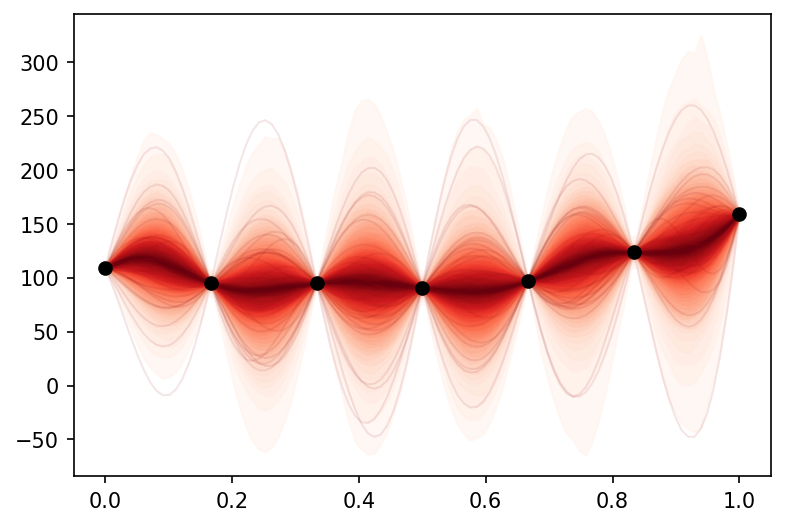

In [83]:
# 새로 정의된 샘플링 축은 (0, 1) 범위라고 가정합니다. 2차원 위치 변수의 매개변수로 생각할 수 있습니다.
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
y_pred_samples = az.extract(samples, group="posterior_predictive", var_names=["z_pred"])
y_pred_samples = y_pred_samples * (y_max - y_min) + y_min
plot_gp_dist(ax, samples=y_pred_samples.T, x=np.linspace(0, 1, 100))
# for i in range(100):
#     z_val = samples.posterior_predictive.z_pred.stack(sample=("draw", "chain")).isel(sample=i)
#     ax.plot(np.linspace(0, 1, 100), z_val, alpha=0.05, color='red')
ax.plot(np.linspace(0, 1, 7), z[1:7+1] * (y_max - y_min) + y_min, 'o', color='black', label='True')
# ax.set_ylim(0, 0.2)
plt.show()